In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Flatten, GRU
from keras.models import Sequential

In [2]:
file = open('/Users/gursharan/Desktop/jena_climate_2009_2016.csv', 'r')
reader = csv.reader(file)
header = next(reader, None)
data= []
for line in reader:
    data.append([line[0]] + [ float(x) for x in line[1:] ] )

In [3]:
print(header)

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


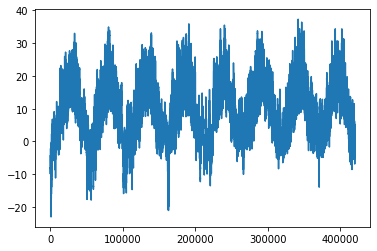

In [4]:
# we can see the cycles over year-scale.
_ = plt.plot(range(len(data)), [x[2] for x in data])

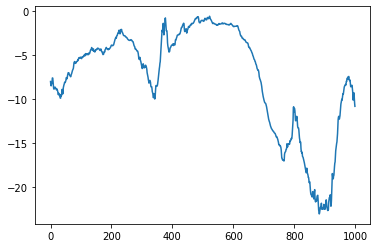

In [5]:
# we don't really at day-scale - so can we predict temperatures at day scale?
_ = plt.plot(range(1000), [x[2] for x in data[0:1000]])

In [6]:
# normalize - we must normalize only using testing data!!
train_values = 200000
val_values = 100000 #rest is testing
test_values = len(data)-100000
data = [x[1:] for x in data ] #no timestamp

data_for_norm = data[:train_values]
mean = np.mean( data_for_norm, axis =0)
std = np.std( data_for_norm, axis=0 )

data = (data - mean)/std

In [7]:
# define lookback, target delay and steps
# one sample is taken every 10 minute
lookback  = 10*24*6*1 # 10 days
steps = 6*1  #one hour
delay = 24*6*1 # 1 day

In [8]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    #output should be input and output for RNN
    
    if max_index == None:
        max_index = len(data) - delay #maximum initial val for max_index
    i = min_index + lookback #initial value
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback #back to initial value
            rows = range(i, min(i+batch_size, max_index))
            i = i + len(rows)
            
        samples = np.zeros( (len(rows), lookback//step,
                           data.shape[-1] ) )
        targets = np.zeros( (len(rows), ))
        for j,row in enumerate(rows):
            indices = range(row- lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row + delay][1] #first is temperature
        yield samples, targets

In [9]:
train_gen = generator( data, lookback=lookback, delay=delay, min_index =0,
                     max_index = train_values, shuffle=True, step=steps)

val_gen = generator( data, lookback=lookback, delay=delay, min_index =train_values,
                     max_index = train_values + val_values, step=steps)

test_gen = generator( data, lookback=lookback, delay=delay, min_index=train_values + val_values,
                    max_index = None, step= steps)

val_steps = val_values - lookback
test_steps = len(data) - val_values - train_values - lookback

In [11]:
# ESTABLISH BASELINE
def baseline1():
    maes = [] #mean absolute error
    for step in range(val_steps):
        samples, targets = next(val_gen)
        prediction = samples[:, -1, 1] #temperature right now
        mae = np.mean(np.abs(prediction - targets))
        maes.append(mae)
    print(np.mean(maes))

baseline1()

0.289698321176401


In [16]:
temp_mae = std[1] *0.28969 #actual value for temperature MAE in degree celsius
temp_mae

2.564480459123854

#### worse than baseline !! Moving on to RNN

Epoch 1/20
1000/1000 [==============================] - 126s 126ms/step - loss: 0.2932 - val_loss: 0.5378
Epoch 2/20
1000/1000 [==============================] - 131s 131ms/step - loss: 0.2764 - val_loss: 0.4407
Epoch 3/20
1000/1000 [==============================] - 133s 133ms/step - loss: 0.2691 - val_loss: 0.1636
Epoch 4/20
1000/1000 [==============================] - 135s 135ms/step - loss: 0.2617 - val_loss: 0.0908
Epoch 5/20
1000/1000 [==============================] - 138s 138ms/step - loss: 0.2527 - val_loss: 0.2504
Epoch 6/20
1000/1000 [==============================] - 138s 138ms/step - loss: 0.2441 - val_loss: 0.1687
Epoch 7/20
1000/1000 [==============================] - 139s 139ms/step - loss: 0.2350 - val_loss: 0.2215
Epoch 8/20
1000/1000 [==============================] - 140s 140ms/step - loss: 0.2257 - val_loss: 0.2217
Epoch 9/20
1000/1000 [==============================] - 141s 141ms/step - loss: 0.2167 - val_loss: 0.3080
Epoch 10/20
1000/1000 [=======================

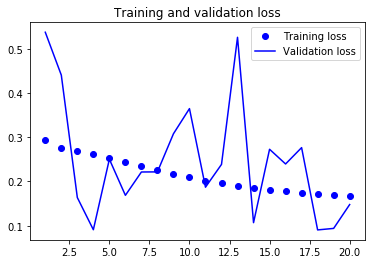

In [27]:
model = Sequential()
model.add(GRU(32, input_shape=(None, data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history_gru = model.fit_generator(train_gen, steps_per_epoch=1000, epochs=20,
                                 validation_data=val_gen, validation_steps=1000)


loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
_ = plt.show()